# 5G NR PUSCH Tutorial

This notebook provides an introduction to Sionna's [5G New Radio (NR) module](https://nvlabs.github.io/sionna/phy/api/nr.html) and, in particular, the [physical uplink shared channel (PUSCH)](https://nvlabs.github.io/sionna/phy/api/nr.html#pusch). This module provides implementations of a small subset of the physical layer functionalities as described in the 3GPP specifications [38.211](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3213), [38.212](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3214) and [38.214](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3216). 


You will

- Get an understanding of the different components of a PUSCH configuration, such as the carrier, DMRS, and transport block,
- Learn how to rapidly simulate PUSCH transmissions for multiple transmitters,
- Modify the PUSCHReceiver to use a custom MIMO Detector.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [A "Hello World!" Example](#A-Hello-World-Example)
* [Carrier Configuration](#Carrier-Configuration)
* [Understanding the DMRS Configuration](#Understanding-the-DMRS-Configuration)
    * [Configuring Multiple Layers](#Configuring-Multiple-Layers)
    * [Controlling the Number of DMRS Symbols in a Slot](#Controlling-the-Number-of-DMRS-Symbols-in-a-Slot)
    * [How to control the number of available DMRS ports?](#How-to-control-the-number-of-available-DMRS-ports?)
* [Transport Blocks and MCS](#Transport-Blocks-and-MCS)
* [Looking into the PUSCHTransmitter](#Looking-into-the-PUSCHTransmitter)
* [Components of the PUSCHReceiver](#Components-of-the-PUSCHReceiver)
* [End-to-end PUSCH Simulations](#End-to-end-PUSCH-Simulations)


## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.phy.config.seed = 42 # Set seed for reproducible results

# Load the required Sionna components
from sionna.phy import Block
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.channel import AWGN, RayleighBlockFading, OFDMChannel, \
                               TimeChannel, time_lag_discrete_time_channel
from sionna.phy.channel import gen_single_sector_topology as gen_topology
from sionna.phy.channel.tr38901 import AntennaArray, UMi, UMa, RMa
from sionna.phy.utils import compute_ber, ebnodb2no, sim_ber
from sionna.phy.ofdm import KBestDetector, LinearDetector
from sionna.phy.mimo import StreamManagement

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

## A Hello World Example

Let us start with a simple "Hello, World!" example in which we will simulate PUSCH transmissions from a single transmitter to a single receiver over an AWGN channel.

In [3]:
# Create a PUSCH configuration with default settings
pusch_config = PUSCHConfig()

# Instantiate a PUSCHTransmitter from the PUSCHConfig
pusch_transmitter = PUSCHTransmitter(pusch_config)

# Create a PUSCHReceiver using the PUSCHTransmitter
pusch_receiver = PUSCHReceiver(pusch_transmitter)

# AWGN channel
channel = AWGN()

# Simulate transmissions over the AWGN channel
batch_size = 16
no = 0.1 # Noise variance

x, b = pusch_transmitter(batch_size) # Generate transmit signal and info bits

y = channel(x, no) # Simulate channel output

b_hat = pusch_receiver(y, no) # Recover the info bits

# Compute BER
print("BER:", compute_ber(b, b_hat).numpy())

BER: 0.0


Although the above code snippet seems rather simple, you have actually carried out standard-compliant simulations of the NR PUSCH!

To better understand what is actually going on under the hood, we can inspect the OFDM resource grid that is generated by the transmitter with the following command:

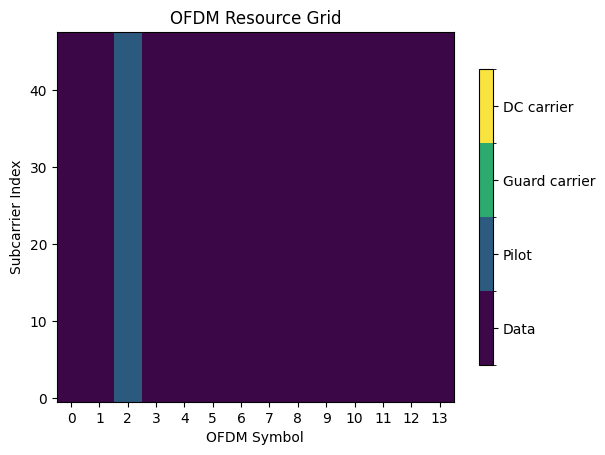

In [4]:
pusch_transmitter.resource_grid.show();

The above figure tells us that we are simulating a slot of 14 OFDM symbols spanning 48 subcarriers, which correspond to four physical resource blocks (PRBs) in 5G terminology. The third OFDM symbol is reserved for pilot transmissions, so-called demodulation reference signals (DMRS), and the rest is used for data. 

## Carrier Configuration

When you create a PUSCHConfig instance, it automatically creates a CarrierConfig instance with default settings.
You can inspect this configuration with the following command:

In [5]:
pusch_config.carrier.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 5.208333333333334e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 0
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 10
num_slots_per_subframe : 1
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 15
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



Most of these parameters cannot be controlled as they are simply derived from others. For example, the cyclic prefix length depends on the subcarrier spacing.
Let us see what happens, when we choose larger subcarrier spacing:

In [6]:
pusch_config.carrier.subcarrier_spacing = 60
pusch_config.carrier.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 1.6927083333333335e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 2
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 40
num_slots_per_subframe : 4
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 60
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



The cyclic prefix has shrunk from $5.2 \mu s$ to $1.69 \mu s$ and the number of slots per frame has increased from $10$ to $40$.

If we change to the extended cyclic prefix, the number of OFDM symbols per slot will decrease from 14 to 12.

In [7]:
pusch_config_ext = pusch_config.clone()
pusch_config_ext.carrier.cyclic_prefix = "extended"
pusch_config_ext.carrier.show()

Carrier Configuration
cyclic_prefix : extended
cyclic_prefix_length : 4.166666666666667e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 2
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 40
num_slots_per_subframe : 4
num_symbols_per_slot : 12
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 60
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



Please have a look at the API documentation of [PUSCHCarrierConfig](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.phy.nr.PUSCHConfig) for more detail.

## Understanding the DMRS Configuration

We can learn more about the structure of the resoure grid by having a look at the pilot pattern in the next section.

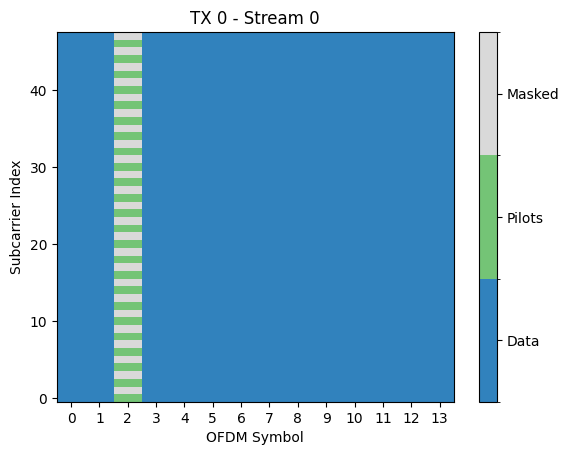

In [8]:
pusch_transmitter.pilot_pattern.show();

From the figure above, we can see that there is a single transmitter sending a single stream (or so-called layer).
DMRS are only sent on even subcarriers while odd subcarriers are masked, i.e., blocked for data transmission.
This corresponds to the DMRS Configuration Type 1 with the parameter `NumCDMGroupsWithoutData` set to 2. We will explain what that means later.

In 5G NR, one can configure many different pilot patterns to adapt to different channel conditions and to allow for spatial multiplexing of up to twelve layers. Each transmitted layer is identified by a DMRS port, i.e., a distinct pilot pattern. In our running example, the transmitter uses the DMRS port 0.

With the current PUSCH configuration, four different DMRS ports 0,1,2,3 are available.
This can be verified with the following command:

In [9]:
pusch_config.dmrs.allowed_dmrs_ports

[0, 1, 2, 3]

Next, we configure three other transmitters using each one of the remaing ports. Then, we create a new PUSCHTransmitter instance from the list of PUSCH configurations which is able to generate transmit signals for all four transmitters in parallel.

In [10]:
# Clone the original PUSCHConfig and change the DMRS port set
pusch_config_1 = pusch_config.clone()
pusch_config_1.dmrs.dmrs_port_set = [1]
pusch_config_2 = pusch_config.clone()
pusch_config_2.dmrs.dmrs_port_set = [2]
pusch_config_3 = pusch_config.clone()
pusch_config_3.dmrs.dmrs_port_set = [3]

# Create a PUSCHTransmitter from the list of PUSCHConfigs
pusch_transmitter_multi = PUSCHTransmitter([pusch_config, pusch_config_1, pusch_config_2, pusch_config_3])

# Generate a batch of random transmit signals
x, b  = pusch_transmitter_multi(batch_size)

# x has shape [batch_size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
print("Shape of x:", x.shape)

Shape of x: (16, 4, 1, 14, 48)


Inspecting the shape of x reveals that we have indeed four single-antenna transmitters. Let us now have a look at the resuling pilot pattern for each of them:

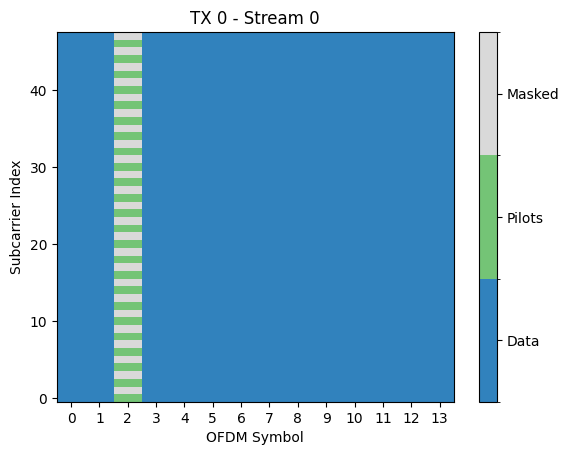

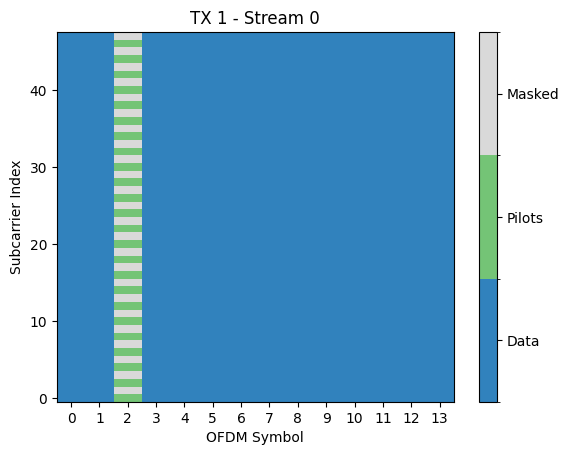

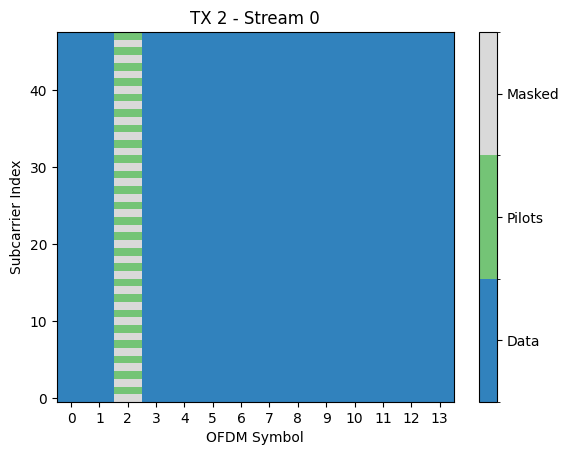

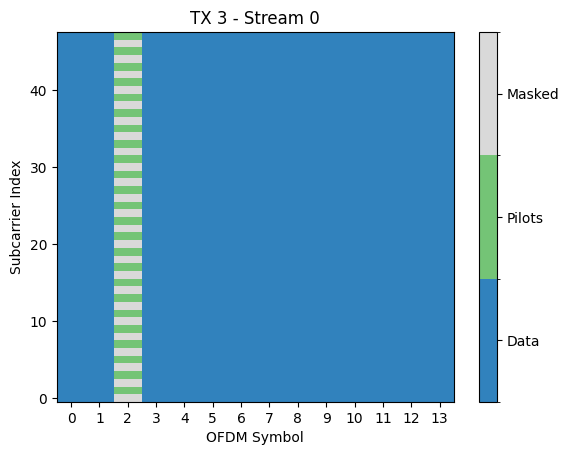

In [11]:
pusch_transmitter_multi.pilot_pattern.show();

As before, all transmitters send pilots only on the third OFDM symbol. Transmitter 0 and 1 (using DMRS port 0 and 1, respectively) send pilots on all even subcarriers, while Transmitter 2 and 3 (using DMRS port 2 and 3, respectively), send pilots on the odd subcarriers.
This means that the pilots signals of DMRS port 0 and 1 (as well as 2 and 3) interfere with each other as they occupy the same resource elements.
So how can we estimate the channel coefficients for both transmitters individually without pilot contamination? 

The solution to this problem are the so-called code division multiplexing (CDM) groups in 5G NR.
DMRS ports 0,1 belong to CDM group 0, while DMRS ports 2,3 belong to CDM group 1.

The pilot signals belonging to the same CDM group are multiplied by orthogonal cover codes which allow separating them during channel estimation.
The way this works is as follows. Denote by $\mathbf{p_0} = [s_1, s_2]^\textsf{T}$ a pair of two adjacent pilot symbols, e.g., those on subcarrier 0 and 2, of DMRS port 0. DMRS port 1 will simply send $\mathbf{p_1} = [s_1, -s_2]^\textsf{T}$. If we assume that the channel is constant over both subcarriers, we get the following received pilot signal at the receiver (we look only at a single antenna here):

\begin{align}
\mathbf{y} = h_0\mathbf{p}_0 + h_1\mathbf{p}_1 + \mathbf{n}
\end{align}

where $\mathbf{y}\in\mathbb{C}^2$ is the received signal on both subcarriers, $h_0, h_1$ are the channel coefficients for both users, and $\mathbf{n}\in\mathbb{C}^2$ is a noise vector.

We can now obtain channel estimates for both transmitters by projecting $\mathbf{y}$ onto their respective pilot sequences:

\begin{align}
\hat{h}_0 &= \frac{\mathbf{p}_0^\mathsf{H}}{\lVert \mathbf{p}_0 \rVert|^2} \mathbf{y} = h_0 + \frac{|s_1|^2-|s_2|^2}{\lVert \mathbf{p}_0 \rVert|^2} h_1 + \frac{\mathbf{p}_0^\mathsf{H}}{\lVert \mathbf{p}_0 \rVert|^2} \mathbf{n} = h_0 + n_0 \\
\hat{h}_1 &= \frac{\mathbf{p}_1^\mathsf{H}}{\lVert \mathbf{p}_1 \rVert|^2} \mathbf{y} = \frac{|s_1|^2-|s_2|^2}{\lVert \mathbf{p}_1 \rVert|^2} h_0 + h_1 +\frac{\mathbf{p}_1^\mathsf{H}}{\lVert \mathbf{p}_1 \rVert|^2} \mathbf{n} = h_1 + n_1.
\end{align}

Since the pilot symbols have the same amplitude, we have $|s_1|^2-|s_2|^2=0$, i.e., the interference between both pilot sequence is zero. Moreover, due to an implict averaging of the channel estimates for both subcarriers, the effective noise variance is reduced by a factor of 3dB since

\begin{align}
\mathbb{E}\left[ |n_0|^2 \right] = \mathbb{E}\left[ |n_1|^2 \right] = \frac{\sigma^2}{\lVert \mathbf{p}_1 \rVert|^2} = \frac{\sigma^2}{2 |s_0|^2}.
\end{align}

We can access the actual pilot sequences that are transmitted as follows:

In [12]:
# pilots has shape [num_tx, num_layers, num_pilots]
pilots = pusch_transmitter_multi.pilot_pattern.pilots
print("Shape of pilots:", pilots.shape)

# Select only the non-zero subcarriers for all sequence
p_0 = pilots[0,0,::2] # Pilot sequence of TX 0 on even subcarriers
p_1 = pilots[1,0,::2] # Pilot sequence of TX 1 on even subcarriers
p_2 = pilots[2,0,1::2] # Pilot sequence of TX 2 on odd subcarriers
p_3 = pilots[3,0,1::2] # Pilot sequence of TX 3 on odd subcarriers

Shape of pilots: (4, 1, 48)


Each pilot pattern consists of 48 symbols that are transmitted on the third OFDM symbol with 4PRBs, i.e., 48 subcarriers. 
Let us now verify that pairs of two adjacent pilot symbols in `p_0` and `p_1` as well as in `p_2` and `p_3` are orthogonal.

In [13]:
print(np.sum(np.reshape(p_0, [-1,2]) * np.reshape(np.conj(p_1), [-1,2]), axis=1))
print(np.sum(np.reshape(p_2, [-1,2]) * np.reshape(np.conj(p_3), [-1,2]), axis=1))

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]


Let us now come back to the masked resource elements in each pilot pattern. 
The parameter `NumCDMGroupsWithoutData` mentioned earlier determines which resource elements in a DMRS-carrying OFDM symbol are masked for data transmissions. This is to avoid inference with pilots from other DMRS groups.

In our example, `NumCDMGroupsWithoutData` is set to two. This means that no data can be transmitted on any of the resource elements occupied by both DMRS groups. However, if we would have set `NumCDMGroupsWithoutData` equal to one, data and pilots would be frequency multiplexed. 
This can be useful, if we only schedule transmissions from DMRS ports in the same CDM group.

Here is an example of such a configuration:

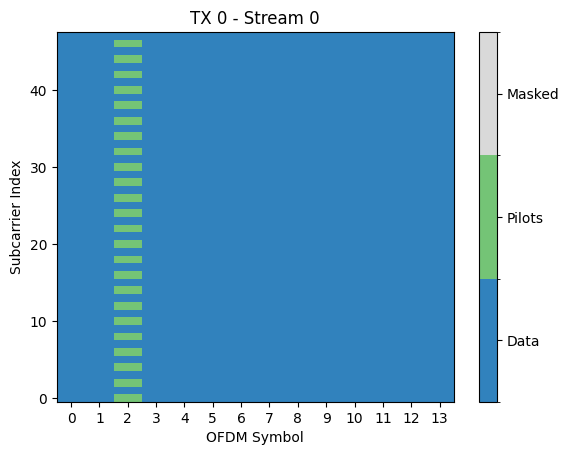

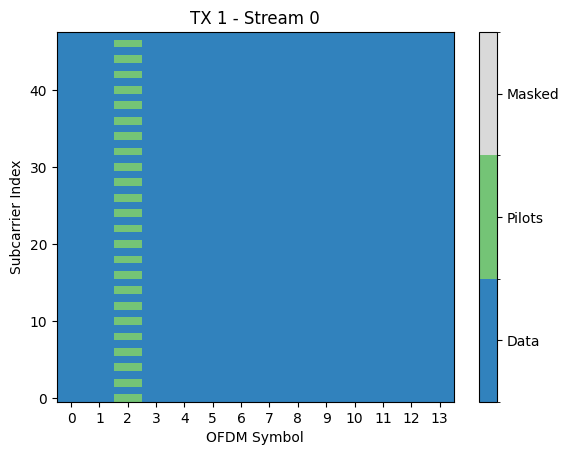

In [14]:
pusch_config = PUSCHConfig()
pusch_config.dmrs.num_cdm_groups_without_data = 1
pusch_config.dmrs.dmrs_port_set = [0]

pusch_config_1 = pusch_config.clone()
pusch_config_1.dmrs.dmrs_port_set = [1]

PUSCHTransmitter([pusch_config, pusch_config_1]).pilot_pattern.show();

The DRMS ports 0 and 1 belong both to CDM group 0 so that the resource elements of CDM group 1 do not need to be masked and can be used for data transmission. One can see in the above figure that data and pilots are now indeed multiplexed in the frequency domain.

### Configuring Multiple Layers

In 5G NR, a transmitter can be equipped with 1,2, or 4 antenna ports, i.e., physical antennas that are fed with an individual transmit signal.
It can transmit 1,2,3 or 4 layers, i.e., spatial streams, as long as the number of layers does not exceed the number of antenna ports. 
Using codebook-based precoding, a number of layers can be mapped onto a larger number of antenna ports, e.g., 2 layers using 4 antenna ports. If no precoding is used, each layer is simply mapped to one of the antenna ports.

It is important to understand that each layer is transmitted using a different DMRS port. That means that the number of DMRS ports is independent of the number of antenna ports.

In the next cell, we will configure a single transmitter with four antenna ports, sending two layers on DMRS ports 0 and 1.
We can then choose among different precoding matrices with the help of the transmit precoding matrix identifier (TPMI). 

In [15]:
pusch_config = PUSCHConfig()
pusch_config.num_antenna_ports = 4
pusch_config.num_layers = 2
pusch_config.dmrs.dmrs_port_set = [0,1]
pusch_config.precoding = "codebook"
pusch_config.tpmi = 7

# Show the precoding matrix
pusch_config.precoding_matrix

array([[0.5+0.j , 0. +0.j ],
       [0. +0.j , 0.5+0.j ],
       [0.5+0.j , 0. +0.j ],
       [0. +0.j , 0. +0.5j]])

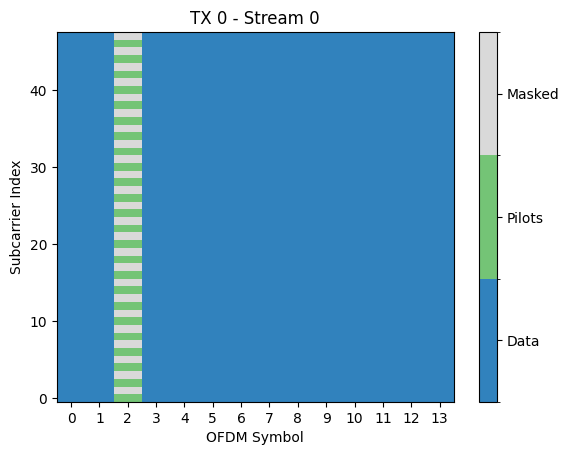

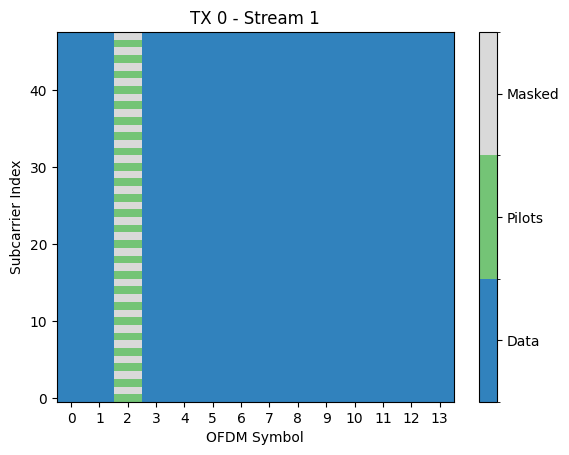

In [16]:
PUSCHTransmitter(pusch_config).pilot_pattern.show();

We can see from the pilot patterns above, that we have now a single transmitter sending two streams. Both streams will be precoded and transmit over four antenna ports. From a channel estimation perspective at the receiver, however, this scenario is identical to the previous one with two single-antenna transmitters. The receiver will simply estimate the effective channel (including precoding) for every configured DMRS port.

### Controlling the Number of DMRS Symbols in a Slot

How can we add additional DMRS symbols to the resource grid to enable channel estimation for high-speed scenarios? 

This can be controlled with the parameter ``DMRS.additional_position``.
In the next cell, we configure one additional DMRS symbol to the pattern and visualize it. You can try setting it to different values and see the impact.

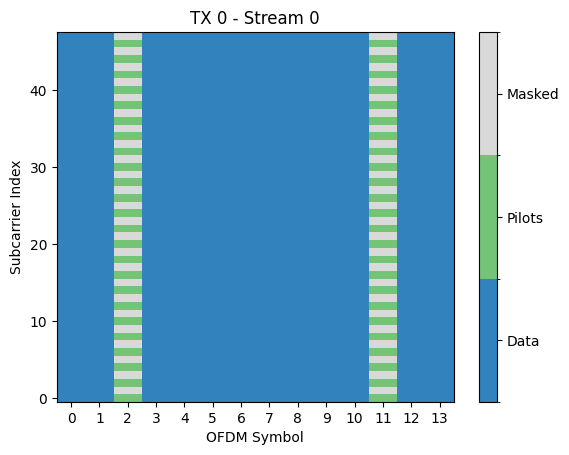

In [17]:
pusch_config.dmrs.additional_position = 1

# In order to reduce the number of figures, we here only show
# the pilot pattern of the first stream
PUSCHTransmitter(pusch_config).pilot_pattern.show(stream_ind = 0);

### How to control the number of available DMRS ports?

There are two factors that determine the available number of DMRS ports, i.e., layers, that can be transmitted. 
The first is the DMRS Configuration and the second the length of a DMRS symbol. Both parameters can take two values so that there are four options in total.
In the previous example, the DMRS Configuration Type 1 was used. In this case, there are two CDM groups and each group uses either odd or even subcarriers. This leads to four available DMRS ports.
With DMRS Configuration Type 2, there are three CDM groups and each group uses two pairs of adjacent subcarriers per PRB, i.e., four pilot-carrying subcarriers. That means that there are six available DMRS ports.





Available DMRS ports: [0, 1, 2, 3]


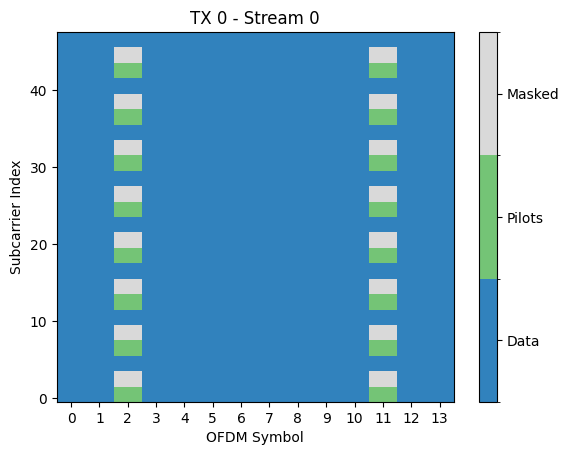

In [18]:
pusch_config.dmrs.config_type = 2
PUSCHTransmitter(pusch_config).pilot_pattern.show(stream_ind = 0);
print("Available DMRS ports:", pusch_config.dmrs.allowed_dmrs_ports)

In the above figure, you can see that the pilot pattern has become sparser in the frequency domain. However, there are still only four available DMRS ports. This is because we now need to mask also the resource elements that are used by the third CDM group. This can be done by setting the parameter `NumCDMGroupsWithoutData` equal to three.

Available antenna ports: [0, 1, 2, 3, 4, 5]


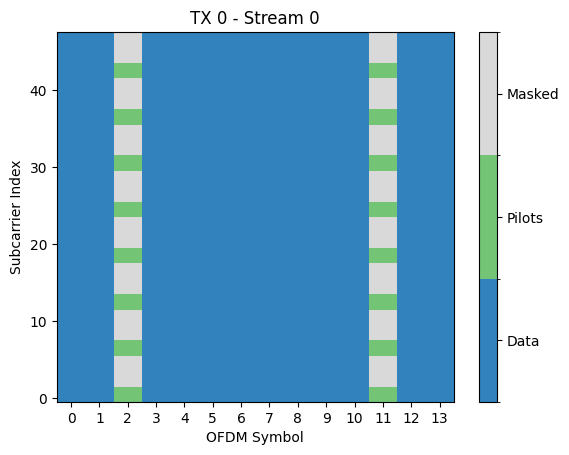

In [19]:
pusch_config.dmrs.num_cdm_groups_without_data = 3
PUSCHTransmitter(pusch_config).pilot_pattern.show(stream_ind = 0);
print("Available antenna ports:", pusch_config.dmrs.allowed_dmrs_ports)

The second parameter that controls the number of available DMRS ports is the ``length``, which can be equal to either one or two.
Let's see what happens when we change it to two.

Available DMRS ports: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


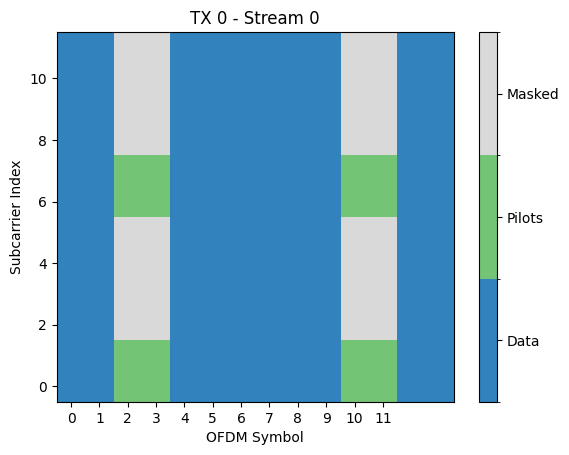

In [20]:
pusch_config.n_size_bwp = 1 # We reduce the bandwidth to one PRB for better visualization
pusch_config.dmrs.length = 2
PUSCHTransmitter(pusch_config).pilot_pattern.show(stream_ind = 0);
print("Available DMRS ports:", pusch_config.dmrs.allowed_dmrs_ports)

The pilot pattern is now composed of four 2x2 blocks within a PRB. These blocks are used by the four DMRS ports within the same CDM group. This means that we can now support up to twelve layers! 

Let's create a setup with three transmitters, each sending four layers using four antenna ports. We choose the DMRS ports for each transmitters such that they belong to the CDM group. This is not necessary and you are free to choose any desired allocation. 
It is however important to understand, that for channel estimation to work, the channel is supposed to be static over 2x2 blocks of resource elements. This is in general the case for low mobility scenarios and channels with not too large delay spread. You can see from the results below that the pilot sequences of the DMRS ports in the same CDM group are indeed orthogonal over the 2x2 blocks.

In [21]:
pusch_config = PUSCHConfig()
pusch_config.n_size_bwp = 1
pusch_config.dmrs.config_type = 2
pusch_config.dmrs.length = 2
pusch_config.dmrs.additional_position = 1
pusch_config.dmrs.num_cdm_groups_without_data = 3
pusch_config.num_antenna_ports = 4
pusch_config.num_layers = 4
pusch_config.dmrs.dmrs_port_set = [0,1,6,7]
pusch_config.precoding = "codebook"
pusch_config.tpmi = 4

pusch_config_1 = pusch_config.clone()
pusch_config_1.dmrs.dmrs_port_set = [2,3,8,9]
pusch_config_2 = pusch_config.clone()
pusch_config_2.dmrs.dmrs_port_set = [4,5,10,11]

pusch_transmitter_multi = PUSCHTransmitter([pusch_config, pusch_config_1, pusch_config_2])

In [22]:
# Extract the first 2x2 block of pilot symbols for all DMRS ports of the first transmitter
p = pusch_transmitter_multi.pilot_pattern.pilots[0].numpy()
p = np.matrix(p[:, [0,1,12,13]])

# Test that these pilot sequences are mutually orthogonal
# The result should be a boolean identity matrix
np.abs(p*p.getH())>1e-6

matrix([[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]])

There are several other parameters that impact the pilot patterns. The full DMRS configuration can be displayed with the following command.
We refer to the [API documentation of the PUSCHDMRSConfig class](https://nvlabs.github.io/sionna/phy/api/nr.html#puschdmrsconfig) for further details.

In [23]:
pusch_config.dmrs.show()

PUSCH DMRS Configuration
additional_position : 1
allowed_dmrs_ports : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
beta : 1.7320508075688772
cdm_groups : [0, 0, 0, 0]
config_type : 2
deltas : [0, 0, 0, 0]
dmrs_port_set : [0, 1, 6, 7]
length : 2
n_id : None
n_scid : 0
num_cdm_groups_without_data : 3
type_a_position : 2
w_f : [[ 1  1  1  1]
 [ 1 -1  1 -1]]
w_t : [[ 1  1  1  1]
 [ 1  1 -1 -1]]



## Transport Blocks and MCS

The modulation and coding scheme (MCS) is set in 5G NR via the MCS index and MCS table which are properties of transport block configuration [TBConfig](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.TBConfig). When you create an instance of ``PUSCHConfig``, a default instance of ``TBConfig`` is created. It can be accessed via the following command:

In [24]:
pusch_config = PUSCHConfig()
pusch_config.tb.show()

Transport Block Configuration
channel_type : PUSCH
mcs_index : 14
mcs_table : 1
n_id : None
num_bits_per_symbol : 4
target_coderate : 0.5400390625
tb_scaling : 1.0



You can see that the current MCS Table is 1 and the MCS index is 14. Looking at the corresponding table in the API documentation of [TBConfig](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.TBConfig), you can see that we should have  a 16QAM modulation (i.e., 4 bits per symbol) and a target coderate of 553/1024=0.54 which matches the values above. The data scrambling ID $n_\text{ID}$ is set to `None` which implies that the physical layer cell id $N^\text{cell}_\text{ID}$ will be used instead.

We can change the MCS index and table as follows:

In [25]:
pusch_config.tb.mcs_index = 26
pusch_config.tb.mcs_table = 2
pusch_config.tb.show()

Transport Block Configuration
channel_type : PUSCH
mcs_index : 26
mcs_table : 2
n_id : None
num_bits_per_symbol : 8
target_coderate : 0.89501953125
tb_scaling : 1.0



The transport block segmentation allows the PUSCH transmitter to fill resource grids of almost arbitrary size and with any of the possible DMRS configurations.
The number of information bits transmitted in a single slot is given by the property ``tb_size`` of the ``PUSCHConfig``.


In [26]:
# Adding more PRBs will increase the TB size
pusch_config.carrier.n_size_grid = 273
pusch_config.tb_size

303240

In [27]:
# Adding more layers will increase the TB size
pusch_config.num_antenna_ports = 4
pusch_config.num_layers = 4
pusch_config.tb_size

1213032

For more details about how the transportblock encoding/decoding works, we refer to the API documentation of the [TBEncoder](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.TBEncoder).

## Looking into the PUSCHTransmitter

We have used the ``PUSCHTransmitter`` class already multiple times without speaking about what it actually does. In short, it generates for every configured transmitter a batch of random information bits of length ``pusch_config.tb_size`` and outputs either a frequency to time-domain representation of the transmitted OFDM waveform from each of the antenna ports of each transmitter.

However, under the hood it implements the sequence of layers shown in the following figure: 

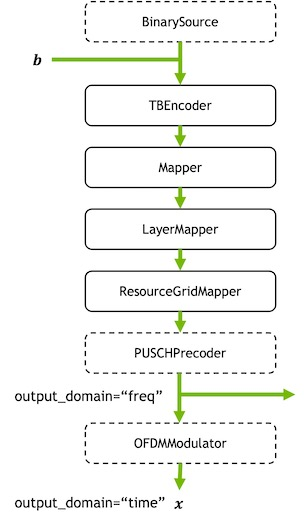

Information bits are either randomly generated or provided as input and then encoded into a transport block by the [TBEncoder](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.TBEncoder). The encoded bits are then mapped to QAM constellation symbols by the [Mapper](https://nvlabs.github.io/sionna/phy/api/mapping.html#sionna.mapping.Mapper). The [LayerMapper](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.LayerMapper) splits the modulated symbols into different layers which are then mapped onto OFDM resource grids by the [ResourceGridMapper](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.ofdm.ResourceGridMapper). If precoding is enabled in the [PUSCHConfig](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHConfig), the resource grids are further precoded by the [PUSCHPrecoder](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHPrecoder) so that there is one for each transmitter and antenna port. If ``output_domain`` equals “freq”, these are the ouputs 
x
. If ``output_domain`` is chosen to be “time”, the resource grids are transformed into time-domain signals by the [OFDMModulator](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.ofdm.OFDMModulator).

Let us configure a ``PUSCHTransmitter`` from a list of two ``PUSCHConfig`` and inspect the output shapes: 

In [28]:
pusch_config = PUSCHConfig()
pusch_config.num_antenna_ports = 4
pusch_config.num_layers = 2
pusch_config.dmrs.dmrs_port_set = [0,1]
pusch_config.precoding = "codebook"
pusch_config.tpmi = 7

pusch_config_1 = pusch_config.clone()
pusch_config.dmrs.dmrs_port_set = [2,3]

pusch_transmitter = PUSCHTransmitter([pusch_config, pusch_config_1])

batch_size = 32
x, b = pusch_transmitter(batch_size)

# b has shape [batch_size, num_tx, tb_size]
print("Shape of b:", b.shape)

# x has shape [batch_size, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
print("Shape of x:", x.shape)

Shape of b: (32, 2, 2728)
Shape of x: (32, 2, 4, 14, 48)


If you want to transmit a custom payload, you simply need to deactive the ``return_bits`` flag when creating the transmitter:

In [29]:
pusch_transmitter = PUSCHTransmitter([pusch_config, pusch_config_1], return_bits=False)
x_2 = pusch_transmitter(b)
assert np.array_equal(x, x_2) # Check that we get the same output for the payload b generated above

By default, the ``PUSCHTransmitter`` generates frequency-domain outputs. If you want to make time-domain simulations, you need to configure the ``output_domain`` during the initialization:

In [30]:
pusch_transmitter = PUSCHTransmitter([pusch_config, pusch_config_1], output_domain="time", return_bits=False)
x_time = pusch_transmitter(b)

# x has shape [batch_size, num_tx, num_tx_ant, num_time_samples]
print("Shape of x:", x_time.shape)

Shape of x: (32, 2, 4, 728)


The last dimension of the output signal correspond to the total number of time-domain samples which can be computed in the following way:

In [31]:
(pusch_transmitter.resource_grid.cyclic_prefix_length  \
 + pusch_transmitter.resource_grid.fft_size) \
* pusch_transmitter.resource_grid.num_ofdm_symbols

728

## Components of the PUSCHReceiver

The [PUSCHReceiver](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHReceiver) is the counter-part to the [PUSCHTransmitter](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHTransmitter) as it *simply* recovers the transmitted information bits from received waveform. It combines multiple processing blocks in a single layer as shown in the following figure:

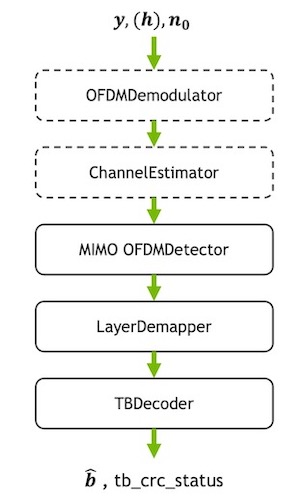

If the ``input_domain`` equals “time”, the inputs $\mathbf{y}$
 are first transformed to resource grids with the [OFDMDemodulator](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.ofdm.OFDMModulator). Then channel estimation is performed, e.g., with the help of the [PUSCHLSChannelEstimator](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHLSChannelEstimator). If ``channel_estimator`` is chosen to be “perfect”, this step is skipped and the input $\mathbf{h}$ is used instead. Next, MIMO detection is carried out with an arbitrary [OFDMDetector](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.ofdm.OFDMDetector). The resulting LLRs for each layer are then combined to transport blocks with the help of the [LayerDemapper](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.LayerDemapper). Finally, the transport blocks are decoded with the [TBDecoder](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.TBDecoder).
 
If we instantiate a ``PUSCHReceiver`` as done in the next cell, default implementations of all blocks as described in the [API documentation](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.nr.PUSCHReceiver) are used.  


In [32]:
pusch_receiver = PUSCHReceiver(pusch_transmitter)
pusch_receiver._mimo_detector

We can also provide custom implementations for each block by providing them as keyword arguments during initialization.
In the folllwing code snippet, we first create an instance of the [KBestDetector](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.ofdm.KBestDetector), which is then used as MIMO detector in the ``PUSCHReceiver``.

In [33]:
# Create a new PUSCHTransmitter
pusch_transmitter = PUSCHTransmitter([pusch_config, pusch_config_1])

# Create a StreamManagement instance
rx_tx_association = np.ones([1, pusch_transmitter.resource_grid.num_tx], bool)
stream_management = StreamManagement(rx_tx_association,
                                     pusch_config.num_layers)

# Get relevant parameters for the detector
num_streams = pusch_transmitter.resource_grid.num_tx \
              * pusch_transmitter.resource_grid.num_streams_per_tx

k = 32 # Number of canditates for K-Best detection

k_best = KBestDetector("bit", num_streams, k,
                       pusch_transmitter.resource_grid,
                       stream_management,
                       "qam", pusch_config.tb.num_bits_per_symbol)

# Create a PUSCHReceiver using the KBest detector
pusch_receiver = PUSCHReceiver(pusch_transmitter, mimo_detector=k_best)

Next, we test if this receiver works over a simple Rayleigh block fading channel:

In [34]:
num_rx_ant = 16
rayleigh = RayleighBlockFading(num_rx=1,
                               num_rx_ant=num_rx_ant,
                               num_tx=pusch_transmitter.resource_grid.num_tx,
                               num_tx_ant=pusch_config.num_antenna_ports)

channel = OFDMChannel(rayleigh,
                      pusch_transmitter.resource_grid,
                      add_awgn=True,
                      normalize_channel=True)

x, b = pusch_transmitter(32)
no = 0.1
y = channel(x, no)
b_hat = pusch_receiver(y, no)
print("BER:", compute_ber(b, b_hat).numpy())

BER: 0.0


## End-to-end PUSCH Simulations

We will now implement an end-to-end model that is capable of running PUSCH simulations for many different configurations.
You can use it as a boilerplate template for your own experiments.

In [35]:
class Model(Block):
    """Simulate PUSCH transmissions over a 3GPP 38.901 model

    This model runs BER simulations for a multiuser MIMO uplink channel
    compliant with the 5G NR PUSCH specifications.
    You can pick different scenarios, i.e., channel models, perfect or
    estimated CSI, as well as different MIMO detectors (LMMSE or KBest).
    You can chosse to run simulations in either time ("time") or frequency ("freq")
    domains and configure different user speeds.

    Parameters
    ----------
    scenario : str, one of ["umi", "uma", "rma"]
        3GPP 38.901 channel model to be used

    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated

    domain :  str, one of ["freq", "time"]
        Domain in which the simulations are carried out.
        Time domain modelling is typically more complex but allows modelling
        of realistic effects such as inter-symbol interference of subcarrier
        interference due to very high speeds.

    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.

    speed: float
        User speed (m/s)

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 scenario,    # "umi", "uma", "rma"
                 perfect_csi, # bool
                 domain,      # "freq", "time"
                 detector,    # "lmmse", "kbest"
                 speed        # float
                ):
        super().__init__()
        self._scenario = scenario
        self._perfect_csi = perfect_csi
        self._domain = domain
        self._speed = speed

        self._carrier_frequency = 3.5e9
        self._subcarrier_spacing = 30e3
        self._num_tx = 4
        self._num_tx_ant = 4
        self._num_layers = 2
        self._num_rx_ant = 16
        self._mcs_index = 14
        self._mcs_table = 1
        self._num_prb = 16

        # Create PUSCHConfigs

        # PUSCHConfig for the first transmitter
        pusch_config = PUSCHConfig()
        pusch_config.carrier.subcarrier_spacing = self._subcarrier_spacing/1000
        pusch_config.carrier.n_size_grid = self._num_prb
        pusch_config.num_antenna_ports = self._num_tx_ant
        pusch_config.num_layers = self._num_layers
        pusch_config.precoding = "codebook"
        pusch_config.tpmi = 1
        pusch_config.dmrs.dmrs_port_set = list(range(self._num_layers))
        pusch_config.dmrs.config_type = 2
        pusch_config.dmrs.length = 2
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.num_cdm_groups_without_data = 3
        pusch_config.tb.mcs_index = self._mcs_index
        pusch_config.tb.mcs_table = self._mcs_table

        # Create PUSCHConfigs for the other transmitters by cloning of the first PUSCHConfig
        # and modifying the used DMRS ports.
        pusch_configs = [pusch_config]
        for i in range(1, self._num_tx):
            pc = pusch_config.clone()
            pc.dmrs.dmrs_port_set = list(range(i*self._num_layers, (i+1)*self._num_layers))
            pusch_configs.append(pc)

        # Create PUSCHTransmitter
        self._pusch_transmitter = PUSCHTransmitter(pusch_configs, output_domain=self._domain)

        # Create PUSCHReceiver
        self._l_min, self._l_max = time_lag_discrete_time_channel(self._pusch_transmitter.resource_grid.bandwidth)


        rx_tx_association = np.ones([1, self._num_tx], bool)
        stream_management = StreamManagement(rx_tx_association,
                                             self._num_layers)

        assert detector in["lmmse", "kbest"], "Unsupported MIMO detector"
        if detector=="lmmse":
            detector = LinearDetector(equalizer="lmmse",
                                      output="bit",
                                      demapping_method="maxlog",
                                      resource_grid=self._pusch_transmitter.resource_grid,
                                      stream_management=stream_management,
                                      constellation_type="qam",
                                      num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
        elif detector=="kbest":
            detector = KBestDetector(output="bit",
                                     num_streams=self._num_tx*self._num_layers,
                                     k=64,
                                     resource_grid=self._pusch_transmitter.resource_grid,
                                     stream_management=stream_management,
                                     constellation_type="qam",
                                     num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)

        if self._perfect_csi:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain,
                                                 channel_estimator="perfect",
                                                 l_min = self._l_min)
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain,
                                                 l_min = self._l_min)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                 num_rows=1,
                                 num_cols=int(self._num_tx_ant/2),
                                 polarization="dual",
                                 polarization_type="cross",
                                 antenna_pattern="omni",
                                 carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_rx_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if self._scenario == "umi":
            self._channel_model = UMi(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "uma":
            self._channel_model = UMa(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "rma":
            self._channel_model = RMa(carrier_frequency=self._carrier_frequency,
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)

        # Configure the actual channel
        if domain=="freq":
            self._channel = OFDMChannel(
                                self._channel_model,
                                self._pusch_transmitter.resource_grid,
                                normalize_channel=True,
                                return_channel=True)
        else:
            self._channel = TimeChannel(
                                self._channel_model,
                                self._pusch_transmitter.resource_grid.bandwidth,
                                self._pusch_transmitter.resource_grid.num_time_samples,
                                l_min=self._l_min,
                                l_max=self._l_max,
                                normalize_channel=True,
                                return_channel=True)

    def new_topology(self, batch_size):
        """Set new topology"""
        topology = gen_topology(batch_size,
                                self._num_tx,
                                self._scenario,
                                min_ut_velocity=self._speed,
                                max_ut_velocity=self._speed)

        self._channel_model.set_topology(*topology)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        x, b = self._pusch_transmitter(batch_size)

        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       self._pusch_transmitter._target_coderate,
                       self._pusch_transmitter.resource_grid)
        y, h = self._channel(x, no)
        if self._perfect_csi:
            b_hat = self._pusch_receiver(y, no, h)
        else:
            b_hat = self._pusch_receiver(y, no)
        return b, b_hat

We will now compare the PUSCH BLER performance over the 3GPP 38.901 UMi channel model with different detectors and either perfect or imperfect CSI.
Note that these simulations might take some time depending or you available hardware. You can reduce the `batch_size` if the model does not fit into the memory of your GPU. Running the simulations in the time domain will significantly increase the complexity and you might need to decrease the `batch_size` further. The code will also run on CPU if not GPU is available. 

If you do not want to run the simulation yourself, you can skip the next cell and visualize the results in the next cell.

In [36]:
PUSCH_SIMS = {
    "scenario" : ["umi"],
    "domain" : ["freq"],
    "perfect_csi" : [True, False],
    "detector" : ["kbest", "lmmse"],
    "ebno_db" : list(range(-2,11)),
    "speed" : 3.0,
    "batch_size_freq" : 128,
    "batch_size_time" : 28, # Reduced batch size from time-domain modeling
    "bler" : [],
    "ber" : []
    }

start = time.time()

for scenario in PUSCH_SIMS["scenario"]:
    for domain in PUSCH_SIMS["domain"]:
        for perfect_csi in PUSCH_SIMS["perfect_csi"]:
            batch_size = PUSCH_SIMS["batch_size_freq"] if domain=="freq" else PUSCH_SIMS["batch_size_time"]
            for detector in PUSCH_SIMS["detector"]:
                model = Model(scenario, perfect_csi, domain, detector, PUSCH_SIMS["speed"])
                ber, bler = sim_ber(model,
                            PUSCH_SIMS["ebno_db"],
                            batch_size=batch_size,
                            max_mc_iter=1000,
                            num_target_block_errors=200)
                PUSCH_SIMS["ber"].append(list(ber.numpy()))
                PUSCH_SIMS["bler"].append(list(bler.numpy()))

PUSCH_SIMS["duration"] = time.time() - start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.0 | 1.3466e-01 | 9.9805e-01 |      564787 |     4194304 |          511 |         512 |        87.6 |reached target block errors
     -1.0 | 8.9700e-02 | 9.0039e-01 |      376227 |     4194304 |          461 |         512 |         0.6 |reached target block errors
      0.0 | 3.9218e-02 | 5.5859e-01 |      164491 |     4194304 |          286 |         512 |         0.6 |reached target block errors
      1.0 | 1.4951e-02 | 2.2852e-01 |      125421 |     8388608 |          234 |        1024 |         1.3 |reached target block errors
      2.0 | 3.6776e-03 | 7.0312e-02 |       92549 |    25165824 |          216 |        3072 |         3.8 |reached target block errors
      3.0 | 1.0105e-03 | 1.6406e-02 |      105957 |   104857600 |

Simulation duration: 1.12 [h]


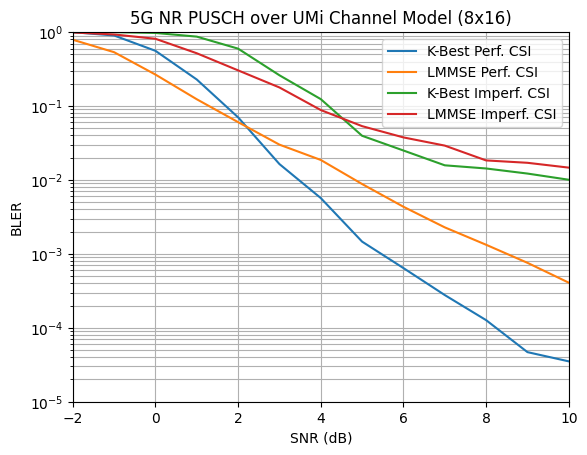

In [37]:
# Uncomment to show precomputed results
#PUSCH_SIMS = eval("{'scenario': ['umi'], 'domain': ['freq'], 'perfect_csi': [True, False], 'detector': ['kbest', 'lmmse'], 'ebno_db': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'speed': 3.0, 'batch_size_freq': 128, 'batch_size_time': 28, 'bler': [[0.865234375, 0.525390625, 0.236328125, 0.0703125, 0.022894965277777776, 0.0081787109375, 0.0031916920731707315, 0.0011800130208333333, 0.0007274208566108007, 0.000298828125, 0.000189453125, 0.000107421875, 4.6875e-05], [0.501953125, 0.2412109375, 0.13411458333333334, 0.06556919642857142, 0.037109375, 0.021073190789473683, 0.012251420454545454, 0.007244318181818182, 0.0038869121287128713, 0.0027646346830985913, 0.0015751008064516128, 0.0009838684538653367, 0.0007239105504587156], [0.994140625, 0.97265625, 0.849609375, 0.513671875, 0.234375, 0.115234375, 0.05126953125, 0.028878348214285716, 0.023092830882352942, 0.018694196428571428, 0.013671875, 0.012451171875, 0.013739224137931034], [0.919921875, 0.724609375, 0.533203125, 0.2802734375, 0.16536458333333334, 0.08984375, 0.056919642857142856, 0.043619791666666664, 0.035006009615384616, 0.02055921052631579, 0.017578125, 0.018465909090909092, 0.01532451923076923]], 'ber': [[0.08414149284362793, 0.03808903694152832, 0.013622879981994629, 0.00516200065612793, 0.0018940899107191297, 0.0006881306568781534, 0.0002859627328267912, 0.00012890001138051352, 9.374645169220823e-05, 3.3643484115600584e-05, 2.6883602142333983e-05, 1.2900114059448242e-05, 6.676435470581055e-06], [0.032366275787353516, 0.015960693359375, 0.009874105453491211, 0.004354306629725865, 0.00270201943137429, 0.0015692459909539473, 0.0008932893926447088, 0.0005442922765558416, 0.0002903820264457476, 0.00021878598441540356, 0.00013986518306116904, 7.878217911185171e-05, 6.43913898992976e-05], [0.15517663955688477, 0.12702298164367676, 0.08907222747802734, 0.036322832107543945, 0.015564680099487305, 0.008847415447235107, 0.005330264568328857, 0.003527675356183733, 0.0029088469112620633, 0.0025938579014369418, 0.002038750155218716, 0.0017822608351707458, 0.001927071604235419], [0.10343790054321289, 0.06611466407775879, 0.043680429458618164, 0.0217667818069458, 0.013199090957641602, 0.007306861877441406, 0.005208117621285575, 0.004094309277004666, 0.003994941711425781, 0.002383282310084293, 0.0023060985233472743, 0.002356225794011896, 0.002158962763272799]], 'duration': 4399.180883407593}")
print("Simulation duration: {:1.2f} [h]".format(PUSCH_SIMS["duration"]/3600))

plt.figure()
plt.title("5G NR PUSCH over UMi Channel Model (8x16)")
plt.xlabel("SNR (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.xlim([PUSCH_SIMS["ebno_db"][0], PUSCH_SIMS["ebno_db"][-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []
for scenario in PUSCH_SIMS["scenario"]:
    for domain in PUSCH_SIMS["domain"]:
        for perfect_csi in PUSCH_SIMS["perfect_csi"]:
            for detector in PUSCH_SIMS["detector"]:
                plt.semilogy(PUSCH_SIMS["ebno_db"], PUSCH_SIMS["bler"][i])
                i += 1
                csi = "Perf. CSI" if perfect_csi else "Imperf. CSI"
                det = "K-Best" if detector=="kbest" else "LMMSE"
                legend.append(det + " " + csi)
plt.legend(legend);

Hopefully you have enjoyed this tutorial on Sionna's 5G NR PUSCH module!

Please have a look at the [API documentation](https://nvlabs.github.io/sionna/phy/api/phy.html) of the various components or the other available [tutorials](https://nvlabs.github.io/sionna/phy/tutorials.html) to learn more.